In [1]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import RMSprop

# Plot training & validation accuracy values: https://keras.io/visualization/#training-history-visualization
plt.rcParams['figure.figsize'] = (15.0, 5.0) # set default size of plots

In [2]:
# fix random seed for reproducibility
seed = 7
tf.random.set_seed(seed)

In [3]:
import tensorflow as tf
# needed to solve the problem with out of GPU memory error 
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [4]:
def PlotLossComparison(loss, val_loss):
    plt.clf()   # clear figure
    #loss = history1_dict['loss']
    #val_loss = history1_dict['val_loss']
    epochs = range(len(loss))
    # "bo" is for "blue dot"
    plt.plot(epochs, loss, 'bo', label='Training loss')
    # b is for "solid red line"
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [5]:
def PlotAccuracyComparison(acc, val_acc):
    plt.clf()   # clear figure
    #acc = history1_dict['accuracy']
    #val_acc = history1_dict['val_accuracy']
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [6]:
def PlotTwoAccuracyComparison(acc1, val_acc1, acc2, val_acc2):
    plt.clf()   # clear figure
    #acc = history1_dict['accuracy']
    #val_acc = history1_dict['val_accuracy']
    epochs = range(len(acc1))
    plt.plot(epochs, acc1, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc1, 'b', label='Validation accuracy')
    plt.plot(epochs, acc2, 'ro', label='Training accuracy')
    plt.plot(epochs, val_acc2, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [7]:
def PlotTwoLossComparison(loss1, val_loss1, loss2, val_loss2):
    plt.clf()   # clear figure
    epochs = range(len(loss1))
    plt.plot(epochs, loss1, 'bo', label='Training loss 1')
    plt.plot(epochs, loss2, 'ro', label='Training loss 2')
    plt.plot(epochs, val_loss1, 'b', label='Validation loss 1')
    plt.plot(epochs, val_loss2, 'r', label='Validation loss 2')
    plt.title('Training and validation loss comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [8]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
def PlotMultipleAccuracyComparison(accs ,val_accs):
    plt.clf()   # clear figure
    #acc = history1_dict['accuracy']
    #val_acc = history1_dict['val_accuracy']
    epochs = range(len(accs[0]))
    for i,  (acc, val_acc, color) in enumerate(zip(accs, val_accs, colors)):
            plt.plot(epochs, acc, f'{color}o', label=f'Training accuracy of model {i+1}')
            plt.plot(epochs, val_acc, f'{color}', label=f'Validation accuracy of model {i+1}')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
def PlotMultipleLossComparison(losses, val_losses):
    plt.clf()   # clear figure
    epochs = range(len(losses[0]))
    for i,  (loss, val_loss, color) in enumerate(zip(losses, val_losses, colors)):
        plt.plot(epochs, loss, f'{color}o', label=f'Training loss of model {i+1}')
        plt.plot(epochs, val_loss, f'{color}', label=f'Validation loss of model {i+1}')
    plt.title('Training and validation loss comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

## ALL MODELS RESULTS

In [9]:
all_accs = []
all_val_accs = []
all_losses = []
all_val_losses = []

## Przykład klasyfikacji binarnej

Klasyfikacja binarna (ang. binary classification, inaczej klasyfikacja dwuklasowa) to klasyfikacja, w której model uczy się klasyfikować dane wejściowe do dwóch przeciwnych klas, np. coś jest „dodatnie” lub „ujemne” czy też „poprawne” lub „błędne”.

Zademonstrujemy to na problemie klasyfikacji recenzji filmowych na recenzje „pozytywne” i „negatywne”, tylko na podstawie treści (słowa) recenzji.

Używamy <a href="https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews">zbioru danych IMDB</a>, który składa się z 50 000 wysoce spolaryzowanych recenzji z Bazy Filmowej Internetu. Recenzje są one podzielone na 25.000 recenzji do nauki i 25.000 do testów, a każdy z tych zbiorów składa się z 50% negatywnych i 50% pozytywnych recenzji. Tak więc zarówno zbiór uczący, jak i zbiór testowy są bardzo dobrze wyważone, co jest ważne, jak wyjaśnimy w dalszych przykładach, gdzie nieraz będziemy musieli zmagać się z problemem wyważenia zbiorów, np. stosując augmentację danych czy inne sposoby.

Dzielimy dane na zbiór uczący i zbiór testowy, aby sprawdzić wydajność wytrenowanego modelu na nowych danych (testowych), które nie były prezentowane w trakcie procesu uczenia (co umożliwia ocenić właściwość uogólniania modelu), ponieważ nawet doskonała poprawność klasyfikacji na danych uczących nie ma żadnej wartości, dopóki nie uzyskamy wysokiej poprawności na danych testowych. Jeśliby nam nie zależało na uogólnianiu, wtedy moglibyśmy po prostu przechowywać powiązania między danymi uczącymi i ich etykietami w bazie danych bez uczenia modelu. Modele sztucznej inteligencji tworzymy zaś po to, by dobrze uogólniały - to jest ta spodziewana inteligencja modelu!

Zbiór danych IMDB to kolejny zbiór danych spakowanych i dostępnych z Kerasa. Dane zostały już wstępnie przetworzone: recenzje (ciągi słów) zostały zamienione na ciągi liczb całkowitych, gdzie każda liczba oznacza określone słowo w słowniku.

Poniższy kod załaduje zbiór danych (przy pierwszym uruchomieniu na komputer zostanie pobranych około 80 MB danych). W naszym eksperymencie (aby oszacować nasz czas) użyjemy tylko 5000 tysięcy najczęściej występujących słów (`num_top_words=5000`) w danych uczących, więc rzadkie słowa zostaną odrzucone, szczególnie że wytrenowanie modelu na nich nie wiele by wnosiło z punktu widzenia uogólniania:

In [10]:
from keras.datasets import imdb

num_top_words=7000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_top_words)

Zmienne `train_data` i `test_data` to listy recenzji. Każda recenzja to lista indeksów słówn (zakodowany ciąg słów).

Zmienne `train_labels` i `test_labels` są listami zer i jedynek, gdzie $0$ oznacza recenzję „negatywną”, a $1$ oznacza „pozytywną”.

Spójrzmy na niektóre dane uczące - identyfikatory słów pierwszej recenzji (ponumerowane od 0):

In [68]:
# train_data[0]

Ponieważ ograniczyliśmy nasz zbiór danych do 5000 najczęstszych słów, żaden indeks słów nie przekroczy 4999. Sprawdźmy więc maksymalny indeks we wszystkich sekwencjach załadowanego zbioru danych uczących:

In [12]:
max([max(sequence) for sequence in train_data])

6999

Możemy rozszyfrować jedną z tych recenzji z powrotem na angielskie słowa:

In [13]:
# set the decoded review id:
decoded_review_id = 0  # you can change it to read the other reviews
# word_index is a dictionary mapping words to an integer index
word_index = imdb.get_word_index()
# We reverse it, mapping integer indices to words back
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# We decode the review; note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[decoded_review_id]])
print(decoded_review)

? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big ? for the whole film but these children are amazing and should be praised for what they have done don't you think the

## Przygotowanie danych

Zwykle musimy przygotować dane przed użyciem ich do trenowania modelu.

W tym przypadku musimy przekształcić nasze listy słów w tensory (wielowymiarowe tablice), co możemy zrobić na dwa różne sposoby:
* Moglibyśmy uzupełnić nasze listy tak, aby wszystkie miały tę samą długość i przekształcić je w tensor liczb całkowitych o kształcie `(samples, word_indices)`. Następnie używamy ich jako pierwszej warstwy w sieci, która jest w stanie obsłużyć takie tensory liczb całkowitych (warstwa `Embedding`).
* Moglibyśmy zakodować nasze listy w trybie one-hot, aby przekształcić je w wektory składające się z samych zer i jedynek. Na przykład, zamieniając ciąg `[3, 5]` na 5000-wymiarowy wektor, który byłby zerami, z wyjątkiem indeksów 3 i 5, gdzie byłyby jedynki. Następnie moglibyśmy użyć jako pierwszej warstwy w naszej sieci warstwy `Dense` zdolnej do obsługi danych wektorowych zmiennoprzecinkowych.

Zwektoryzujmy ręcznie nasze dane, aby uzyskać maksymalną przejrzystość:

In [14]:
def vectorize_sequences(sequences, dimension=num_top_words):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        # set specific indices of results[i] to 1s to indicate the words occurring in the sequence
        results[i, sequence] = 1.
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)

Spójrzmy na wynik:

In [15]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

Powinniśmy również zwektoryzować nasze etykiety:

In [16]:
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [17]:
y_train[0]

1.0

Nasze dane wejściowe to po prostu wektory, a nasze etykiety to skalary (0s i 2s). To najprostsza konfiguracja, z jaką kiedykolwiek się spotkasz.

In [18]:
x_train[:3]

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

## Budowa sieci neuronowej

Teraz jesteśmy gotowi do stworzenia i dostarczenia sieci neuronowej przygotowanych danych do nauki, ale jak optymalnie zbudować sieć neuronową? Ile warstw użyć? Ile jednostek w ukrytych warstwach utworzyć? Warstwy ukryte to wszystkie warstwy między wejściową a wyjściową warstwą sieci. W tych warstwach zwykle używamy funkcji „relu” (rektyfikowana jednostka liniowa). W warstwie wyjściowej możemy zastosować funkcję sigmoidalną, której wyjścia znajdują się w przedziale `[0, 1]`, dzięki czemu wyjścia mogą być interpretowane jako prawdopodobieństwo, iż zaprezentowane wejście należy do określonej klasy.

In [19]:
model1 = models.Sequential()
model1.add(layers.Dense(16, activation='relu', input_shape=(num_top_words,)))
model1.add(layers.Dense(8, activation='relu'))
model1.add(layers.Dense(1, activation='sigmoid'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                112016    
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 112,161
Trainable params: 112,161
Non-trainable params: 0
_________________________________________________________________


Do klasyfikacji binarnej możemy użyć `binary_crossentropy` jako funkcji straty:

In [20]:
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import RMSprop

model1.compile(optimizer=optimizers.RMSprop(learning_rate=0.001),   # 'rmsprop'
               loss='binary_crossentropy',
               metrics=['accuracy'])

## Zbieranie danych o wydajności oraz walidacja modelu

Do walidacji modelu powinniśmy zadbać o wydzielenie podzbioru danych testowych, które nigdy nie będą wykorzystywane podczas uczenia:

In [21]:
x_val = x_train[:num_top_words]
partial_x_train = x_train[num_top_words:]

y_val = y_train[:num_top_words]
partial_y_train = y_train[num_top_words:]

Nauczmy więc nasz model i zbierzmy tymczasowe wyniki w obiekcie `History`, aby później narysować wykres:

In [22]:
history1 = model1.fit(partial_x_train,
                      partial_y_train,
                      epochs=20,
                      batch_size=256,
                      validation_data=(x_val, y_val))

Epoch 1/20
71/71 [==============================] - 1s 10ms/step - loss: 0.4712 - accuracy: 0.8019 - val_loss: 0.3298 - val_accuracy: 0.8824
Epoch 2/20
71/71 [==============================] - 0s 5ms/step - loss: 0.2608 - accuracy: 0.9078 - val_loss: 0.2830 - val_accuracy: 0.8833
Epoch 3/20
71/71 [==============================] - 0s 5ms/step - loss: 0.2039 - accuracy: 0.9277 - val_loss: 0.2733 - val_accuracy: 0.8910
Epoch 4/20
71/71 [==============================] - 0s 5ms/step - loss: 0.1696 - accuracy: 0.9391 - val_loss: 0.2856 - val_accuracy: 0.8893
Epoch 5/20
71/71 [==============================] - 0s 5ms/step - loss: 0.1466 - accuracy: 0.9488 - val_loss: 0.3033 - val_accuracy: 0.8880
Epoch 6/20
71/71 [==============================] - 0s 5ms/step - loss: 0.1259 - accuracy: 0.9559 - val_loss: 0.3355 - val_accuracy: 0.8790
Epoch 7/20
71/71 [==============================] - 0s 5ms/step - loss: 0.1090 - accuracy: 0.9636 - val_loss: 0.3452 - val_accuracy: 0.8810
Epoch 8/20
71/71 [=

Jakie wyniki są przechowywane w obiekcie `History`?

In [23]:
history1_dict = history1.history
history1_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Przyjrzyjmy się, jak zmieniają się straty (`loss`) i dokładność (`accuracy`) dla danych treningowych i testowych podczas treningu sieci:

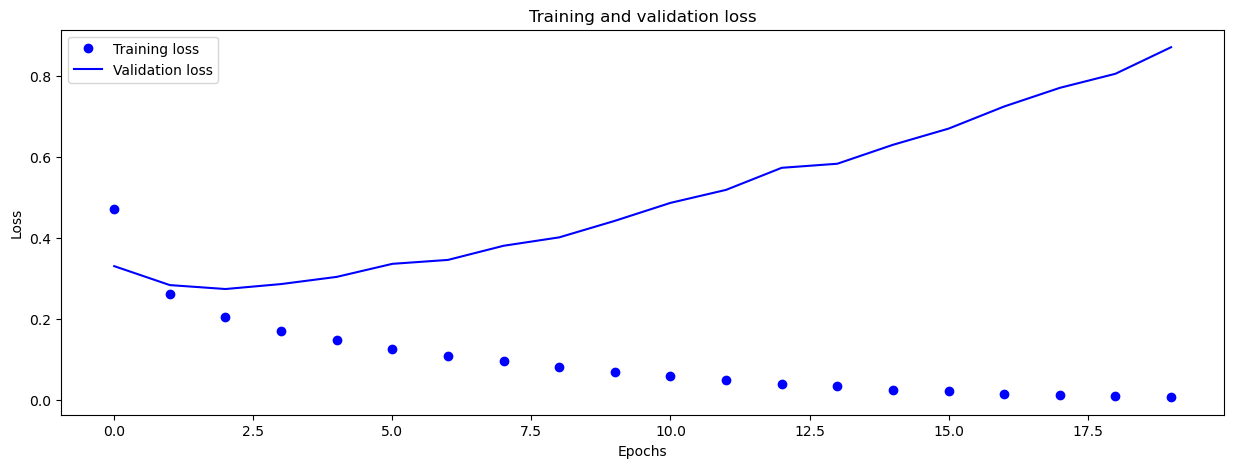

In [24]:
loss1 = history1_dict['loss']
val_loss1 = history1_dict['val_loss']

all_losses.append(loss1)
all_val_losses.append(val_loss1)

PlotLossComparison(loss1, val_loss1)

In [25]:
acc1 = history1_dict['accuracy']
val_acc1 = history1_dict['val_accuracy']


all_accs.append(acc1)
all_val_accs.append(val_acc1)
# PlotAccuracyComparison(acc1, val_acc1)

## Zbytnie dopasowanie modelu do danych uczących (overfitting)

Z przedstawionych wykresów wynika, że nasz model zaczyna się zbytnio dopasowywać do danych uczących już trzeciej epoce treningowej. Mówimy, że ma dużą wariancję. Strata treningowa spada, a dokładność treningu wzrasta, strata walidacyjna rośnie, a dokładność walidacyjna spada.

Oznacza to, że nasz model nie jest wystarczająco dobry dla tego zbioru danych. Projektant powinien być w stanie poradzić sobie z takimi problemami i zrekonstruować model tak, aby jak najbardziej zmniejszyć wariancję, osiągając dobrą właściwość uogólniania modelu. W odwrotnym przypadku model będzie bezużyteczny!

Co możemy zrobić, aby zwiększyć wydajność modelu na danych walidacyjnych?

Spróbuj użyć:
* mniej (1) lub więcej (3 lub 4) warstw ukrytych;
* w warstwach zmniejsz lub zwiększ liczbę jednostek ukrytych (neuronów), np.: 16, 32 lub 64 jednostki;
* innej funkcji straty `mse` zamiast `binary_crossentropy`;
* innej funkcji aktywacji, np. `tanh` lub `elu` zamiast `relu`;
* zwiększ liczbę danych treningowych;
i zobacz, jak wpływa to na walidację i dokładność testów.

Wykonaj te zmiany osobno, aby zauważyć, która zmiana (którego hiperparametru) poprawia wyniki, a która wręcz przeciwnie go psuje?

In [26]:
model2 = models.Sequential()
model2.add(layers.Dense(8, activation='relu', input_shape=(num_top_words,)))
model2.add(layers.Dense(8, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 8)                 56008     
                                                                 
 dense_4 (Dense)             (None, 8)                 72        
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 56,089
Trainable params: 56,089
Non-trainable params: 0
_________________________________________________________________


In [27]:
model2.compile(optimizer=optimizers.RMSprop(learning_rate=0.001),   # 'rmsprop'
               loss='binary_crossentropy',
               metrics=['accuracy'])

In [28]:
history2 = model2.fit(partial_x_train,
                      partial_y_train,
                      epochs=20,
                      batch_size=256,
                      validation_data=(x_val, y_val))
history2_dict = history2.history
history2_dict.keys()

Epoch 1/20
71/71 [==============================] - 1s 8ms/step - loss: 0.5513 - accuracy: 0.7617 - val_loss: 0.4455 - val_accuracy: 0.8666
Epoch 2/20
71/71 [==============================] - 0s 5ms/step - loss: 0.3505 - accuracy: 0.8982 - val_loss: 0.3244 - val_accuracy: 0.8811
Epoch 3/20
71/71 [==============================] - 0s 5ms/step - loss: 0.2435 - accuracy: 0.9227 - val_loss: 0.2842 - val_accuracy: 0.8904
Epoch 4/20
71/71 [==============================] - 0s 5ms/step - loss: 0.1941 - accuracy: 0.9361 - val_loss: 0.2839 - val_accuracy: 0.8879
Epoch 5/20
71/71 [==============================] - 0s 5ms/step - loss: 0.1653 - accuracy: 0.9451 - val_loss: 0.2853 - val_accuracy: 0.8891
Epoch 6/20
71/71 [==============================] - 0s 5ms/step - loss: 0.1421 - accuracy: 0.9514 - val_loss: 0.3034 - val_accuracy: 0.8860
Epoch 7/20
71/71 [==============================] - 0s 6ms/step - loss: 0.1243 - accuracy: 0.9600 - val_loss: 0.3146 - val_accuracy: 0.8850
Epoch 8/20
71/71 [==

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

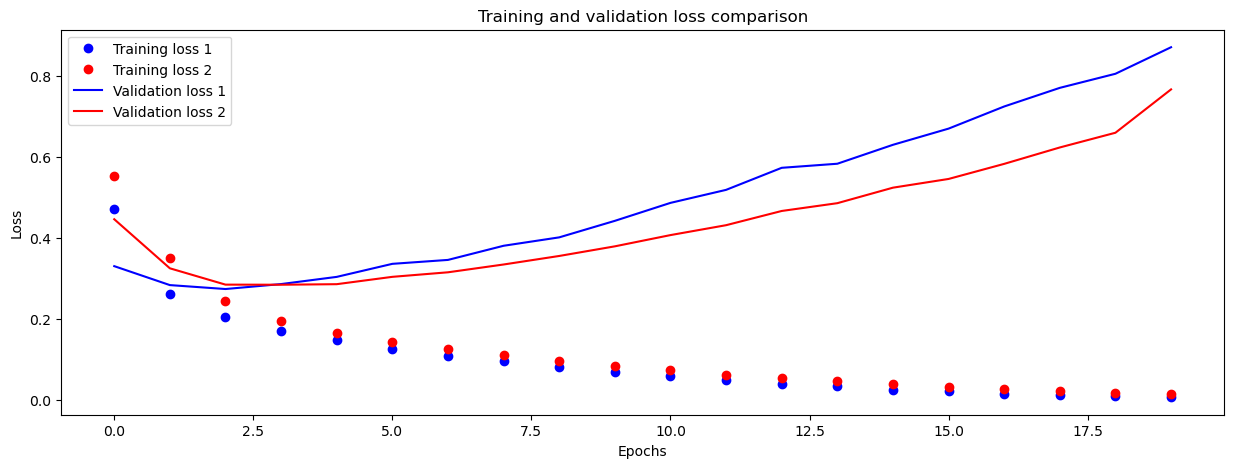

In [29]:
loss1 = history1_dict['loss']
loss2 = history2_dict['loss']
val_loss1 = history1_dict['val_loss']
val_loss2 = history2_dict['val_loss']

all_losses.append(loss2)
all_val_losses.append(val_loss2)

PlotTwoLossComparison(loss1, val_loss1, loss2, val_loss2)

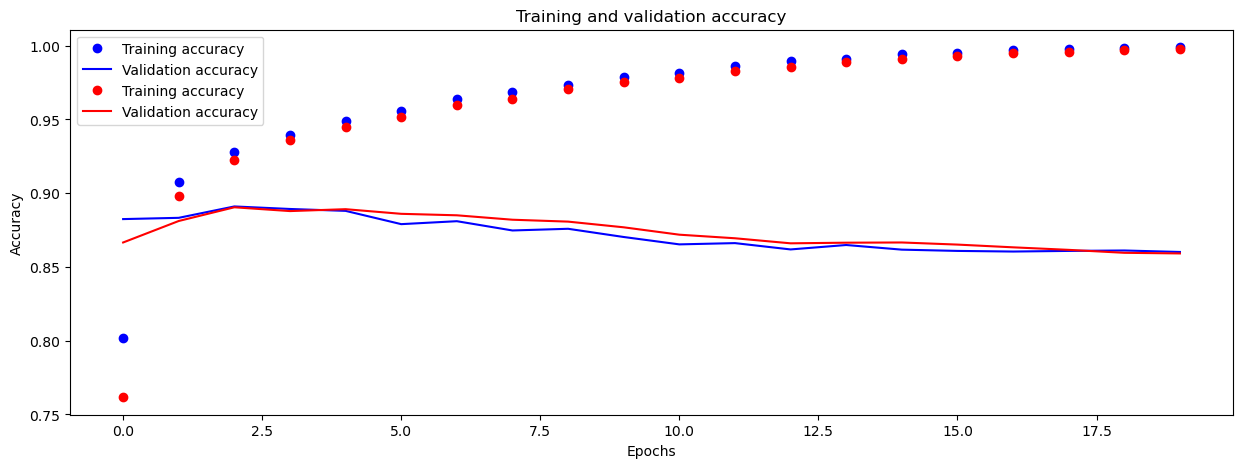

In [30]:
acc2 = history2_dict['accuracy']
val_acc2 = history2_dict['val_accuracy']

all_accs.append(acc2)
all_val_accs.append(val_acc2)

PlotTwoAccuracyComparison(acc1, val_acc1, acc2, val_acc2)

## Model 3

In [31]:
model3 = models.Sequential()
model3.add(layers.Dense(32, activation='relu', input_shape=(num_top_words,)))
model3.add(layers.Dense(32, activation='relu'))
model3.add(layers.Dense(16, activation='relu'))
model3.add(layers.Dense(1, activation='sigmoid'))

In [32]:
model3.compile(optimizer=optimizers.RMSprop(learning_rate=0.001),   # 'rmsprop'
               loss='mse',
               metrics=['accuracy'])

In [33]:
history3 = model3.fit(partial_x_train,
                      partial_y_train,
                      epochs=20,
                      batch_size=256,
                      validation_data=(x_val, y_val))

Epoch 1/20
71/71 [==============================] - 1s 10ms/step - loss: 0.1366 - accuracy: 0.8192 - val_loss: 0.0891 - val_accuracy: 0.8873
Epoch 2/20
71/71 [==============================] - 0s 7ms/step - loss: 0.0713 - accuracy: 0.9079 - val_loss: 0.0873 - val_accuracy: 0.8827
Epoch 3/20
71/71 [==============================] - 0s 7ms/step - loss: 0.0539 - accuracy: 0.9320 - val_loss: 0.0852 - val_accuracy: 0.8881
Epoch 4/20
71/71 [==============================] - 0s 7ms/step - loss: 0.0429 - accuracy: 0.9468 - val_loss: 0.0885 - val_accuracy: 0.8859
Epoch 5/20
71/71 [==============================] - 0s 6ms/step - loss: 0.0351 - accuracy: 0.9578 - val_loss: 0.0986 - val_accuracy: 0.8727
Epoch 6/20
71/71 [==============================] - 0s 7ms/step - loss: 0.0270 - accuracy: 0.9688 - val_loss: 0.0969 - val_accuracy: 0.8774
Epoch 7/20
71/71 [==============================] - 0s 7ms/step - loss: 0.0208 - accuracy: 0.9773 - val_loss: 0.0984 - val_accuracy: 0.8790
Epoch 8/20
71/71 [=

Jakie wyniki są przechowywane w obiekcie `History`?

In [34]:
history3_dict = history3.history
history3_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Przyjrzyjmy się, jak zmieniają się straty (`loss`) i dokładność (`accuracy`) dla danych treningowych i testowych podczas treningu sieci:

In [35]:
loss3 = history3_dict['loss']
val_loss3 = history3_dict['val_loss']
acc3 = history3_dict['accuracy']
val_acc3 = history3_dict['val_accuracy']


all_accs.append(acc3)
all_val_accs.append(val_acc3)
all_losses.append(loss3)
all_val_losses.append(val_loss3)

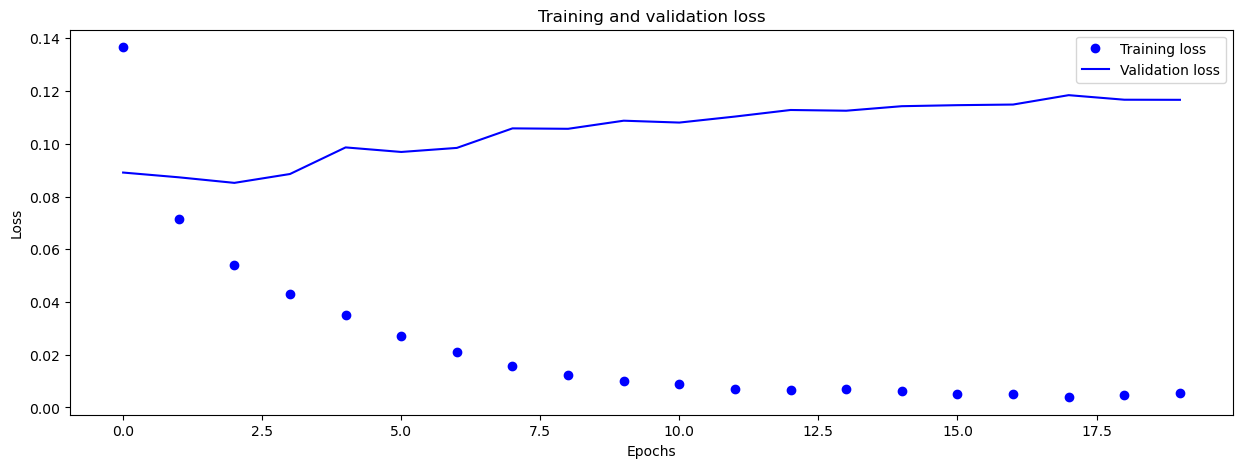

In [36]:
PlotLossComparison(loss3, val_loss3)

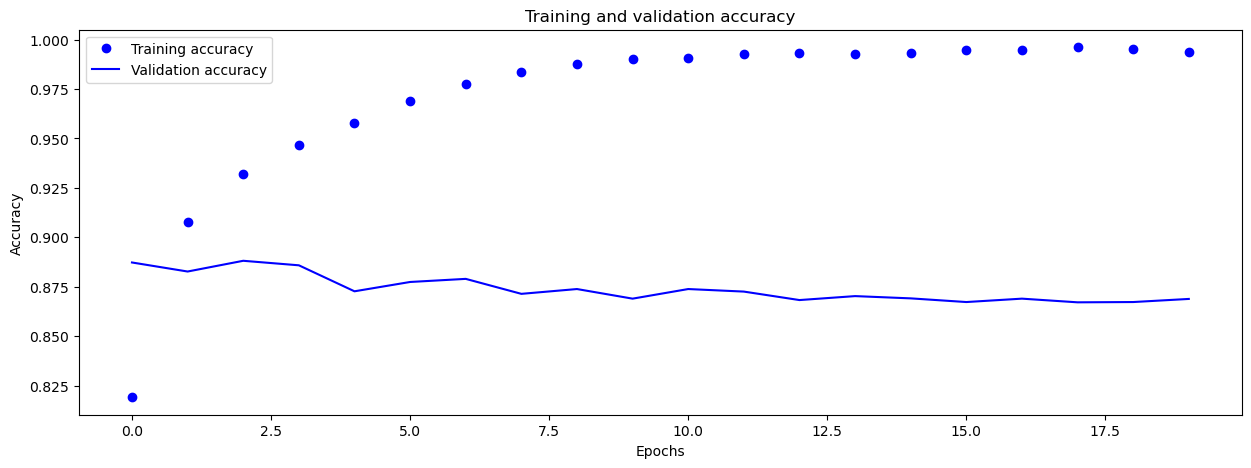

In [37]:
PlotAccuracyComparison(acc3, val_acc3)

#### Dodanie kolejnej warstwy ukrytej o 64 neuronach prowadzi do jeszcze większego overfittingu. Dokładność na danych treningowych dochodzi dość szybko do ~99%, natomiast na danych walidacyjnych oscyluje wokół 87%. <br>Występuje wysoka wariancja. Praktycznie przez cały okres uczenia dokładność  oraz strata walidacyjna pozostają bez zmian.

## Model 4

In [38]:
model4 = models.Sequential()
model4.add(layers.Dense(64, activation='relu', input_shape=(num_top_words,)))
model4.add(layers.Dense(1, activation='sigmoid'))

model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 64)                448064    
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 448,129
Trainable params: 448,129
Non-trainable params: 0
_________________________________________________________________


Do klasyfikacji binarnej możemy użyć `binary_crossentropy` jako funkcji straty:

In [39]:
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import RMSprop

model4.compile(optimizer=optimizers.RMSprop(learning_rate=0.001),   # 'rmsprop'
               loss='binary_crossentropy',
               metrics=['accuracy'])

In [40]:
history4 = model4.fit(partial_x_train,
                      partial_y_train,
                      epochs=20,
                      batch_size=128,
                      validation_data=(x_val, y_val))

Epoch 1/20
141/141 [==============================] - 2s 9ms/step - loss: 0.3517 - accuracy: 0.8557 - val_loss: 0.2889 - val_accuracy: 0.8847
Epoch 2/20
141/141 [==============================] - 1s 6ms/step - loss: 0.2154 - accuracy: 0.9167 - val_loss: 0.2963 - val_accuracy: 0.8831
Epoch 3/20
141/141 [==============================] - 1s 8ms/step - loss: 0.1742 - accuracy: 0.9338 - val_loss: 0.3026 - val_accuracy: 0.8831
Epoch 4/20
141/141 [==============================] - 1s 6ms/step - loss: 0.1393 - accuracy: 0.9483 - val_loss: 0.3302 - val_accuracy: 0.8796
Epoch 5/20
141/141 [==============================] - 1s 6ms/step - loss: 0.1170 - accuracy: 0.9559 - val_loss: 0.3537 - val_accuracy: 0.8796
Epoch 6/20
141/141 [==============================] - 1s 6ms/step - loss: 0.0951 - accuracy: 0.9660 - val_loss: 0.3963 - val_accuracy: 0.8720
Epoch 7/20
141/141 [==============================] - 1s 6ms/step - loss: 0.0749 - accuracy: 0.9733 - val_loss: 0.4321 - val_accuracy: 0.8724
Epoch 

Jakie wyniki są przechowywane w obiekcie `History`?

In [41]:
history4_dict = history4.history
history4_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Przyjrzyjmy się, jak zmieniają się straty (`loss`) i dokładność (`accuracy`) dla danych treningowych i testowych podczas treningu sieci:

In [42]:
loss4 = history4_dict['loss']
val_loss4 = history4_dict['val_loss']
acc4 = history1_dict['accuracy']
val_acc4 = history1_dict['val_accuracy']


all_accs.append(acc4)
all_val_accs.append(val_acc4)
all_losses.append(loss4)
all_val_losses.append(val_loss4)

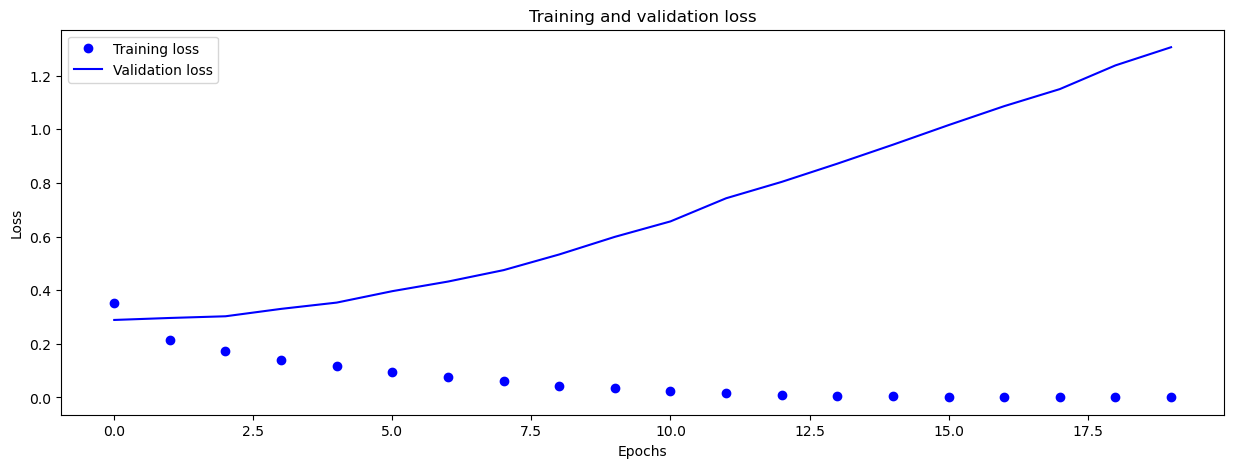

In [43]:
PlotLossComparison(loss4, val_loss4)

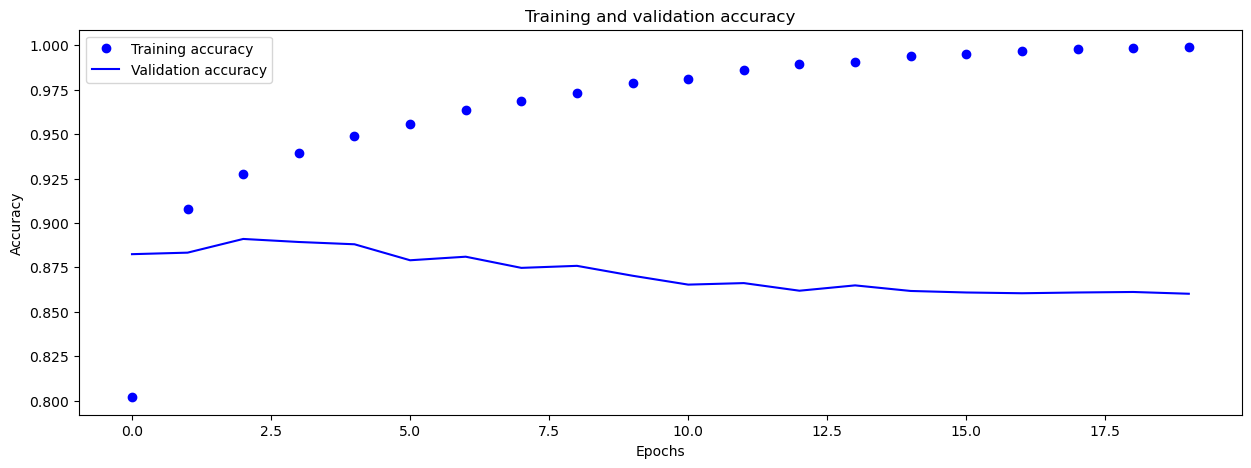

In [44]:
PlotAccuracyComparison(acc4, val_acc4)

### Zmniejszenie ilości warstw ukrytych oraz nauczenie sieci przy dwukrotnie większej ilości epok także nie przyniosło zadowalających skutków. Szybko dochodzi do overfittingu.

### Pora poeksperymentować z wartościami funkcji straty oraz funkcji aktywacji

## Model 5

In [45]:
model5 = models.Sequential()
model5.add(layers.Dense(8, activation='elu', input_shape=(num_top_words,)))
model5.add(layers.Dense(8, activation='elu'))
model5.add(layers.Dense(1, activation='sigmoid'))

model5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 8)                 56008     
                                                                 
 dense_13 (Dense)            (None, 8)                 72        
                                                                 
 dense_14 (Dense)            (None, 1)                 9         
                                                                 
Total params: 56,089
Trainable params: 56,089
Non-trainable params: 0
_________________________________________________________________


In [46]:
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import RMSprop

model5.compile(optimizer=optimizers.RMSprop(learning_rate=0.001),   # 'rmsprop'
               loss='binary_crossentropy',
               metrics=['accuracy'])

In [47]:
history5 = model5.fit(partial_x_train,
                      partial_y_train,
                      epochs=20,
                      batch_size=256,
                      validation_data=(x_val, y_val))

Epoch 1/20
71/71 [==============================] - 1s 9ms/step - loss: 0.4425 - accuracy: 0.8253 - val_loss: 0.3283 - val_accuracy: 0.8799
Epoch 2/20
71/71 [==============================] - 0s 5ms/step - loss: 0.2571 - accuracy: 0.9102 - val_loss: 0.2780 - val_accuracy: 0.8891
Epoch 3/20
71/71 [==============================] - 0s 5ms/step - loss: 0.1959 - accuracy: 0.9283 - val_loss: 0.2750 - val_accuracy: 0.8899
Epoch 4/20
71/71 [==============================] - 0s 6ms/step - loss: 0.1609 - accuracy: 0.9416 - val_loss: 0.3047 - val_accuracy: 0.8880
Epoch 5/20
71/71 [==============================] - 0s 5ms/step - loss: 0.1390 - accuracy: 0.9520 - val_loss: 0.3157 - val_accuracy: 0.8854
Epoch 6/20
71/71 [==============================] - 0s 5ms/step - loss: 0.1200 - accuracy: 0.9578 - val_loss: 0.3635 - val_accuracy: 0.8790
Epoch 7/20
71/71 [==============================] - 0s 5ms/step - loss: 0.1063 - accuracy: 0.9648 - val_loss: 0.3766 - val_accuracy: 0.8793
Epoch 8/20
71/71 [==

Jakie wyniki są przechowywane w obiekcie `History`?

In [48]:
history5_dict = history5.history
history5_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Przyjrzyjmy się, jak zmieniają się straty (`loss`) i dokładność (`accuracy`) dla danych treningowych i testowych podczas treningu sieci:

In [49]:
loss5 = history5_dict['loss']
val_loss5 = history5_dict['val_loss']
acc5 = history5_dict['accuracy']
val_acc5 = history5_dict['val_accuracy']


all_accs.append(acc5)
all_val_accs.append(val_acc5)
all_losses.append(loss5)
all_val_losses.append(val_loss5)

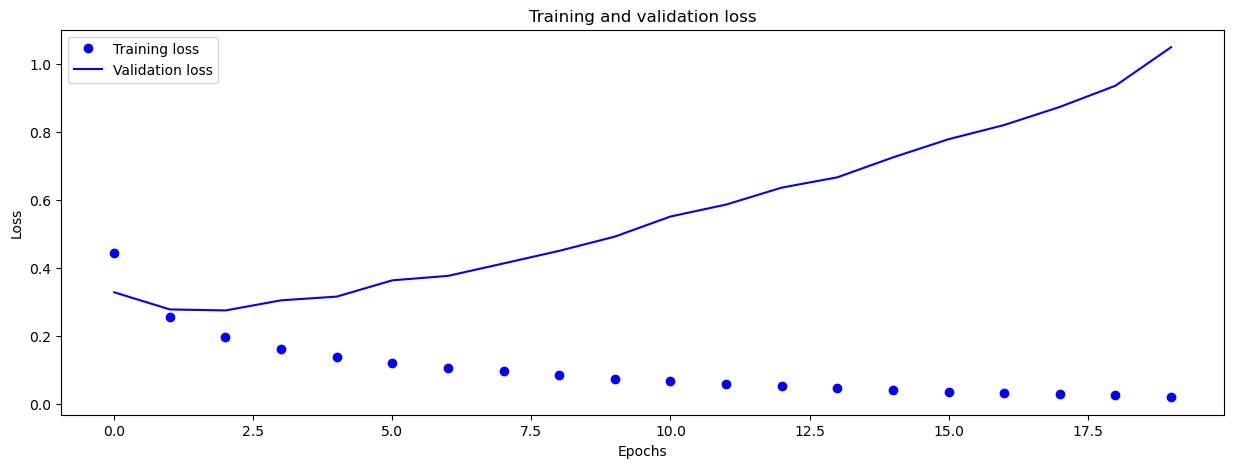

In [50]:
PlotLossComparison(loss5, val_loss5)

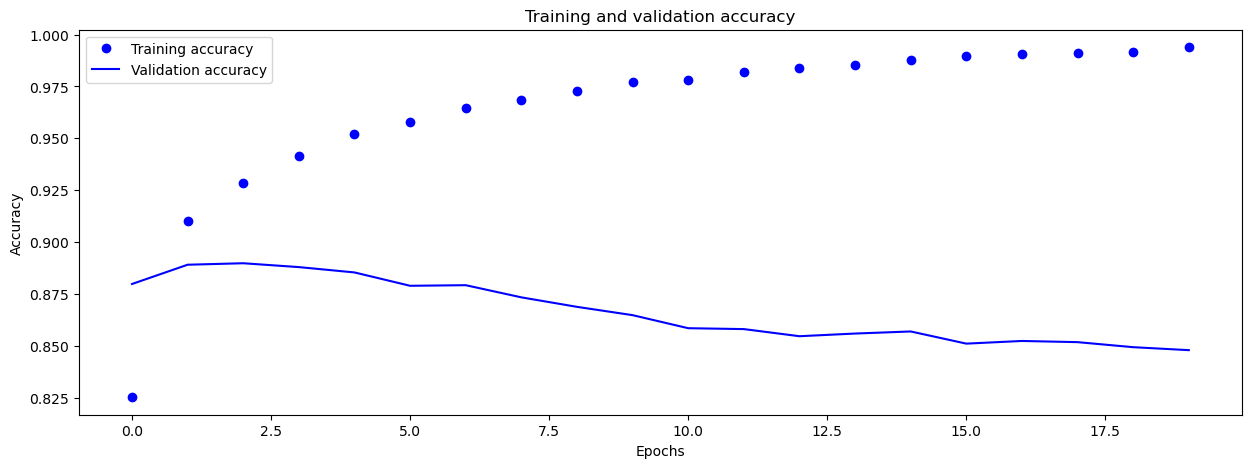

In [51]:
PlotAccuracyComparison(acc5, val_acc5)

#### Przejście z Relu na Elu także nie przynosi oczekiwanych rezultatów - nadal występuje rozbieżność pomiędzy wynikami ze zbioru testowego oraz walidacyjnego.

## Model 6

In [52]:
model6 = models.Sequential()
model6.add(layers.Dense(32, activation='elu', input_shape=(num_top_words,)))
model6.add(layers.Dense(16, activation='sigmoid'))
model6.add(layers.Dense(1, activation='sigmoid'))

model6.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 32)                224032    
                                                                 
 dense_16 (Dense)            (None, 16)                528       
                                                                 
 dense_17 (Dense)            (None, 1)                 17        
                                                                 
Total params: 224,577
Trainable params: 224,577
Non-trainable params: 0
_________________________________________________________________


In [53]:
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import RMSprop

model6.compile(optimizer=optimizers.RMSprop(learning_rate=0.002),   # 'rmsprop'
               loss='binary_crossentropy',
               metrics=['accuracy'])

In [54]:
history6 = model6.fit(partial_x_train,
                      partial_y_train,
                      epochs=20,
                      batch_size=256,
                      validation_data=(x_val, y_val))

Epoch 1/20
71/71 [==============================] - 1s 10ms/step - loss: 0.4164 - accuracy: 0.8381 - val_loss: 0.3053 - val_accuracy: 0.8880
Epoch 2/20
71/71 [==============================] - 0s 6ms/step - loss: 0.2411 - accuracy: 0.9169 - val_loss: 0.2943 - val_accuracy: 0.8817
Epoch 3/20
71/71 [==============================] - 1s 7ms/step - loss: 0.1876 - accuracy: 0.9367 - val_loss: 0.3042 - val_accuracy: 0.8831
Epoch 4/20
71/71 [==============================] - 1s 14ms/step - loss: 0.1570 - accuracy: 0.9483 - val_loss: 0.3188 - val_accuracy: 0.8831
Epoch 5/20
71/71 [==============================] - 1s 8ms/step - loss: 0.1379 - accuracy: 0.9551 - val_loss: 0.3900 - val_accuracy: 0.8674
Epoch 6/20
71/71 [==============================] - 0s 7ms/step - loss: 0.1193 - accuracy: 0.9638 - val_loss: 0.3784 - val_accuracy: 0.8716
Epoch 7/20
71/71 [==============================] - 1s 7ms/step - loss: 0.1072 - accuracy: 0.9676 - val_loss: 0.3896 - val_accuracy: 0.8751
Epoch 8/20
71/71 [

In [55]:
history6_dict = history6.history
history6_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [56]:
loss6 = history6_dict['loss']
val_loss6 = history6_dict['val_loss']
acc6 = history6_dict['accuracy']
val_acc6 = history6_dict['val_accuracy']


all_accs.append(acc6)
all_val_accs.append(val_acc6)
all_losses.append(loss6)
all_val_losses.append(val_loss6)

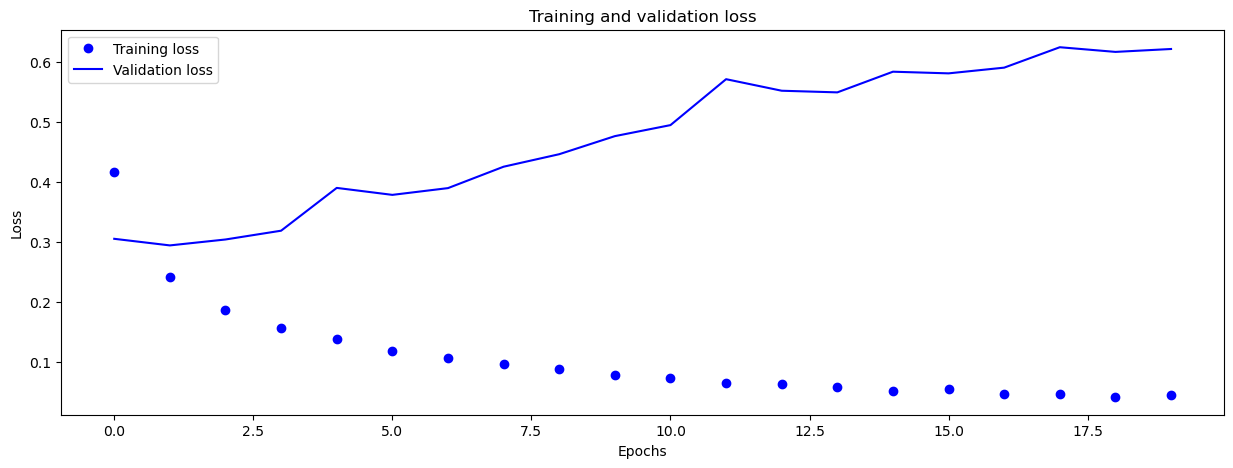

In [57]:
PlotLossComparison(loss6, val_loss6)

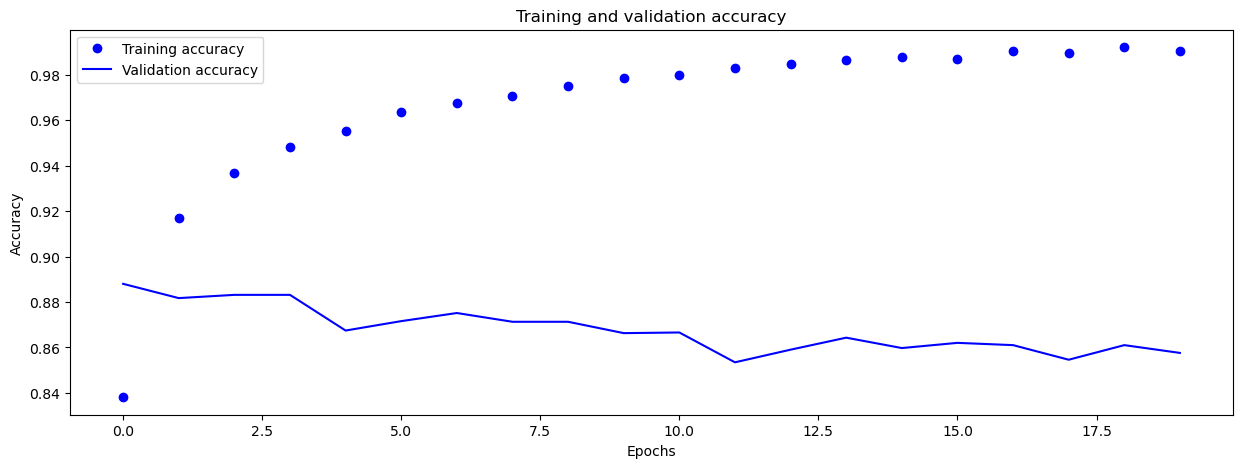

In [58]:
PlotAccuracyComparison(acc6, val_acc6)

## Plot all results on one plot

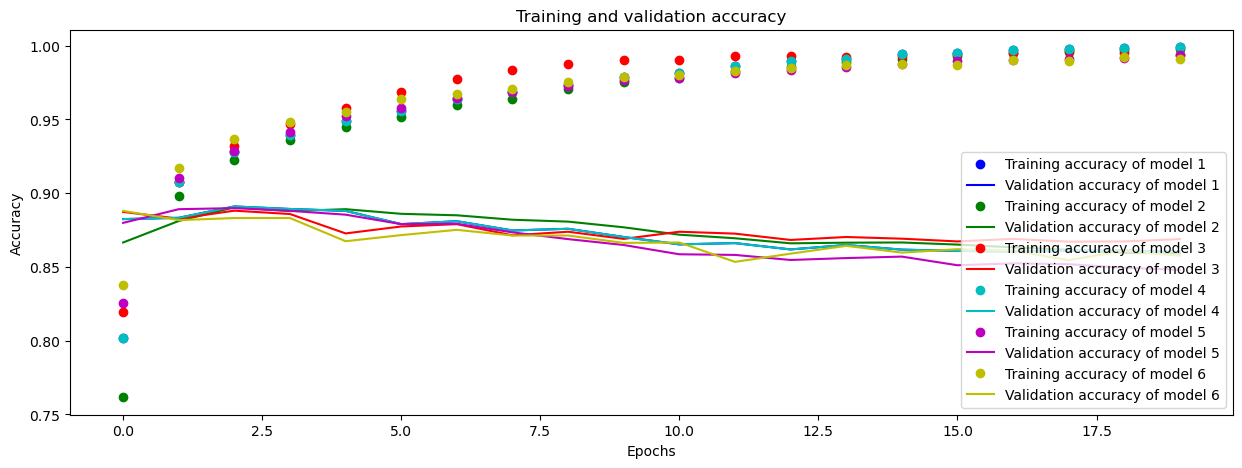

In [59]:
PlotMultipleAccuracyComparison(all_accs, all_val_accs)

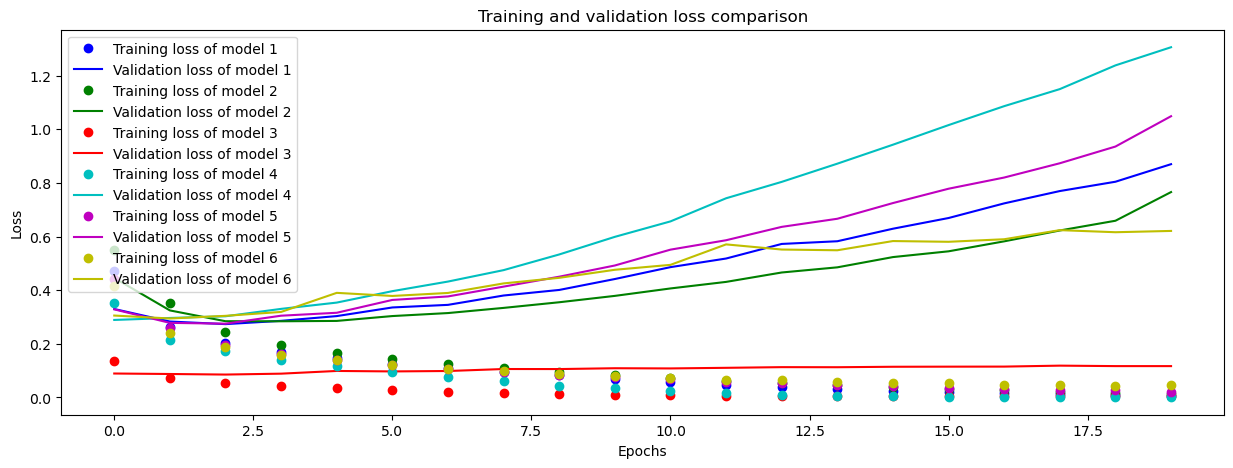

In [60]:
PlotMultipleLossComparison(all_losses, all_val_losses)

#### Wstępne testy nie przynosza oczekiwanych rezultatów. Dokładność na walidacyjnym zbiorze danych dla wszystkich modeli jest bardzo podobna.

Jak widać na wykresie modele przynoszą największą dokładność przy 1 lub 2 epoce. Później wyniki coraz bardziej się rozbiegają - dokładność na zbiorze treningowym wzrastsa, natomiast dokładność na zbiorze walidacyjnym pozostaje taka sama lub maleje. Wzrasta wtedy wariancja modeli. 

In [61]:
second_epoch_results = [res[2] for res in all_val_accs]
second_epoch_results

[0.890999972820282,
 0.8904285430908203,
 0.8881428837776184,
 0.890999972820282,
 0.8898571133613586,
 0.8831428289413452]

Największa dokładność na zbiorze walidacyjnym występuje właśnie przy 2. epoce, którą osiąga czwarty model. Pozostałe modele jednak nie odbiegają znacznie od tego wyniku.

In [62]:
np.array(all_val_accs).max()

0.890999972820282

In [63]:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 64)                448064    
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 448,129
Trainable params: 448,129
Non-trainable params: 0
_________________________________________________________________


Zauważalnie niski błąd walidacyjny w porównaniu do pozostałych modeli posiada model 3. Jest to spowodowane tym, że model 3 korzysta z funkcji straty `Mean Squared Error (MSE)`.
<br> Prowadzi to do wniosku, że mierzenie jest niemiarodajne gdy zastosujemy do porównywanych modeli innnych funkcji straty (porównując wyniki na jednym wykresie).
<br> Co ciekawe po zmianie funkcji straty z `MSE` na `binary_crossentropy` okazuje się że dla tego modelu strata jest największa spośród rozpatrywanych przypadków.

#### Po przetestowaniu kilku architektur z różnymi parametrami nadal nie udało się otrzymać wyniku 90% lub większej dokładności (w przypadku GridSearch na zbiorze testowym) . Najczęściej wyniki wahają się pomiędzy 88-89%.

Próbowanie każdej opcji na osobnym modelu jest wolne i nie widać większych różnic pomiędzy modelami mimo zmiany parametrów, więc postanowiłem użyć GridSearchCV, aby automatycznie uzyskać porównanie wyników dla wielu wariantów parametrów zmieniając przy tym architekturę sieci.
## GridSearchCV

In [102]:
# Use scikit-learn to grid search the activation function
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier


def print_results(grid_result):
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    print("MEAN_TEST_SCORE - STD_TEST_SCORE - PARAMS")
    for mean, stdev, param in zip(means, stds, params):
        print(f"{mean} ({stdev}) with: {param}")

### Test different activation functions in NN with 4 layers - 64, 24, 8, 1 neurons

In [99]:
# Function to create model, required for KerasClassifier
def create_model(activation='relu'):
    # create model
    model = Sequential()
    model.add(layers.Dense(64, activation=activation, input_shape=(num_top_words,)))
    model.add(layers.Dense(24, activation=activation))
    model.add(layers.Dense(8, activation=activation))
    model.add(layers.Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(
        loss='mse', 
        optimizer=optimizers.RMSprop(learning_rate=0.015), 
        metrics=['accuracy'])
    return model


In [100]:
# create model
model = KerasClassifier(model=create_model, epochs=5, batch_size=256, verbose=1)
# define the grid search parameters
activation = ['softmax', 'relu', 'tanh', 'sigmoid', 'elu']
param_grid = dict(model__activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=2, verbose=0)

In [101]:
grid_result = grid.fit(x_train, y_train)

print_results(grid_result)

Epoch 1/5
49/49 [==============================] - 1s 8ms/step - loss: 0.2179 - accuracy: 0.7245
Epoch 2/5
49/49 [==============================] - 0s 8ms/step - loss: 0.1062 - accuracy: 0.9077
Epoch 3/5
49/49 [==============================] - 0s 9ms/step - loss: 0.0683 - accuracy: 0.9269
Epoch 4/5
49/49 [==============================] - 0s 8ms/step - loss: 0.0557 - accuracy: 0.9385
Epoch 5/5
49/49 [==============================] - 0s 4ms/step
Epoch 1/5
49/49 [==============================] - 2s 7ms/step - loss: 0.2186 - accuracy: 0.7386
Epoch 2/5
49/49 [==============================] - 0s 7ms/step - loss: 0.1076 - accuracy: 0.9026
Epoch 3/5
49/49 [==============================] - 0s 7ms/step - loss: 0.0648 - accuracy: 0.9310
Epoch 4/5
49/49 [==============================] - 0s 8ms/step - loss: 0.0486 - accuracy: 0.9474
Epoch 5/5
49/49 [==============================] - 0s 4ms/step
Epoch 1/5
49/49 [==============================] - 1s 7ms/step - loss: 0.1778 - accuracy: 0.7612
E

W zależności od tego czy wykonujemy regresję lub klasyfikację na warstwie wyjściowej wymagana jest odpowiednia funkcja aktywacji. 

W warstwie wyjściowej dla klasyfikacji binarnej można zastosować funkcję sigmoid, której wyjścia znajdują się w przedziale [0, 1], dzięki czemu wyjścia mogą być interpretowane jako prawdopodobieństwo należenia do określonej klasy (wartość prawdopodobieństwa).

Na przykład przy użyciu softmax na wyjściu przy klasyfikacji binarnej otrzymujemy accuracy na poziomie około 50% co nie posiada większego sensu. Softmax ma zastosowanie przy klasyfikacji wieloklasowej, w której otrzymujemy prawdopodobieństwo przynależności odpowiednio dla każdej klasy. Wszystkie otrzymane prawdopodobieństwa sumują się do 1 (100%). Dodatkowo, w tym wypadku trzeba by było zmienić ilość neuronów w warstwie wyjściowej, ponieważ przy użyciu softmax ilość neuronów w warstiwe wyjściowej powinna odpowiadać ilości klas, które rozpatrujemy w klasyfikacji. Także dla 1 neurona w warstwie wyjściowej ustawiłem "na sztywno" funkcję sigmoid, ponieważ inne z nich nie przynosiły zadowalających rezultatów (tak jak wspominałem: softmax miał accuracy 50%, więc konstrukcja nie była w pełni poprawna).

Dlatego ważne jest aby w zależności od celu który chcemy osiągnąć poprawnie dobrać funkcje aktywacji warstwy wyjściowej - jest to podstawowa informacja lecz na pewno warta wspomnienia. W przypadku klasyfikacji binarnej odpowiednią opcją jest np. sigmoid.